# Toy Example - Tabularized GiGL

Latest version of this notebook can be found on [github](https://github.com/Snapchat/GiGL/blob/main/examples/toy_visual_example/toy_example_walkthrough.ipynb)


This notebook provides a walkthrough of preprocessing, subgraph sampling, and split generation components with a small toy graph for GiGL's Tabularized setting for training/inference. It will help you understand how each of these components prepare tabularized subgraphs.

PRO TIP: you can ctrl/cmd + A, right click, then "enable scrolling for outputs"


## Overview Of Components
This notebook demonstrates the process of a simple, human-digestible graph being passed through all the pipeline components in GiGL in preparation for training to help understand how each of the components work.

The pipeline consists of the following components:

- **Config Populator**: Takes a template config and creates a frozen workflow config that dictates all inputs/outputs and business parameters that are read and used by each subsequent component.
    - Input: `template_config.yaml`
    - Output: `frozen_gbml_config.yaml`
&nbsp;

- **Data Preprocessor**: Transforms necessary node and edge feature assets as needed as a precursor step in most ML tasks according to the user-provided data preprocessor config class.
    - Input: `frozen_gbml_config.yaml`, which includes the user-defined preprocessor class for custom logic, and custom arguments can be passed under dataPreprocessorArgs.
    - Output: PreprocessedMetadata Proto, which includes inferred GraphMetadata and preprocessed graph data Tfrecords after applying the user-defined preprocessing function.
&nbsp;

- **Subgraph Sampler**: Samples k-hop subgraphs for each node according to user-provided arguments.
    - Input: `frozen_gbml_config.yaml`, `resource_config.yaml`
    - Output: Subgraph Samples (tfrecord format based on predefined schema in protos) are stored in the URI defined in the flattenedGraphMetadata field.
&nbsp;

- **Split Generator**: Splits subgraph sampler outputs into train/test/val sets according to the user-provided split strategy class.
    - Input: `frozen_gbml_config.yaml`, which includes an instance of SplitStrategy and an instance of Assigner.
    - Output: TFRecord samples.
&nbsp;

- **Trainer**: The trainer component reads the output of the split generator and trains a model on the training set, stops based on the validation set, and evaluates on the test set.
    - Input: `frozen_gbml_config.yaml`
    - Output: state_dict stored in trainedModelUri.
&nbsp;

- **Inferencer**: Runs inference of a trained model on samples generated by the Subgraph Sampler.
    - Input: `frozen_gbml_config.yaml`
    - Output: Embeddings and/or prediction assets.
&nbsp;


In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Silence TF logspam

from gigl.common.utils.jupyter_magics import change_working_dir_to_gigl_root
change_working_dir_to_gigl_root()

2025-08-01 20:13:10.427148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-01 20:13:10.427193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-01 20:13:10.428653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 20:13 [INFO] : Using Any for unsupported type: typing.Sequence[~T] (native_type_compatibility.py:convert_to_beam_type:340)


Changed working directory to: /home/svij/GiGL


## Input Graph

We use the input graph defined in [examples/toy_visual_example/graph_config.yaml](./graph_config.yaml). 
You are welcome to change this file to a custom graph of your own choosing.

### Visualizing the Input Graph

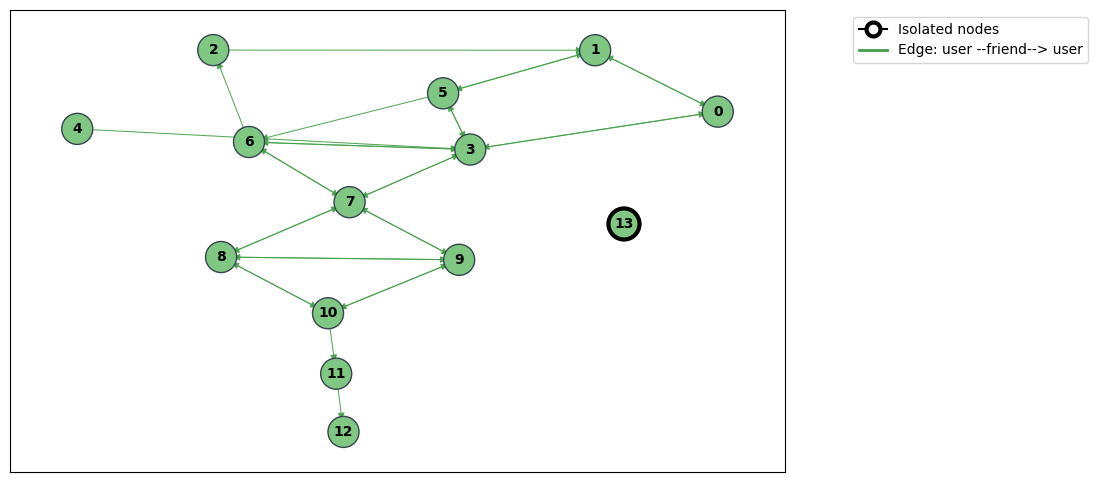

In [2]:
from torch_geometric.data import HeteroData

from gigl.common.utils.jupyter_magics import GraphVisualizer, GraphVisualizerLayoutMode
from gigl.src.mocking.toy_asset_mocker import load_toy_graph


original_graph_heterodata: HeteroData = load_toy_graph(graph_config_path="examples/toy_visual_example/graph_config.yaml")
# Visualize the graph
GraphVisualizer.visualize_graph(original_graph_heterodata, layout_mode=GraphVisualizerLayoutMode.HOMOGENEOUS)

### Setting up Configs

The first thing we need to do is create the resource and task configs. 

- **Task Config**: Specifies task-related configurations, guiding the behavior of components according to the needs of your machine learning task. See [Task Config Guide](../../docs/user_guide/config_guides/task_config_guide.md). For this task, we have already provided a task config: [task_config.yaml](./task_config.yaml).

- **Resource Config**: Details the resource allocation and environmental settings across all GiGL components. This encompasses shared resources for all components, as well as component-specific settings. See [Resource Config Guide](../../docs/user_guide/config_guides/resource_config_guide.md). For this task, we provide a resource [resource_config.yaml](./resource_config.yaml). The provided default values in `shared_resource_config.common_compute_config` will need to be changed.

  - **Instructions to configure the resource config to work**:
    If you have not already, please follow the [Quick Start Guide](../../docs/user_guide/getting_started/quick_start.md) to set up your cloud environment and create a default test resource config. You can then copy the relevant `shared_resource_config.common_compute_config` to [resource_config.yaml](./resource_config.yaml).

In [3]:
import datetime
import getpass
import pathlib
import textwrap
from gigl.common.constants import DEFAULT_GIGL_RELEASE_SRC_IMAGE_DATAFLOW_CPU, DEFAULT_GIGL_RELEASE_SRC_IMAGE_CUDA, DEFAULT_GIGL_RELEASE_SRC_IMAGE_CPU
from gigl.common.utils.gcs import GcsUtils

from gigl.env.pipelines_config import get_resource_config
from gigl.src.common.types.pb_wrappers.gigl_resource_config import GiglResourceConfigWrapper

from gigl.common import Uri, UriFactory
notebook_dir = pathlib.Path("./examples/toy_visual_example").as_posix() # We should be in root dir because of cell # 1

# Add the root gigl dir to the Python path so `example` folder can be imported as a module.

# You are welcome to customize these  to point to your own configuration files.
JOB_NAME = f"{getpass.getuser()}_gigl_toy_example_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
TEMPLATE_TASK_CONFIG_PATH: Uri = UriFactory.create_uri(f"{notebook_dir}/template_task_config.yaml")
FROZEN_TASK_CONFIG_POINTER_FILE_PATH: Uri = UriFactory.create_uri(f"/tmp/GiGL/{JOB_NAME}/frozen_task_config.yaml")
pathlib.Path(FROZEN_TASK_CONFIG_POINTER_FILE_PATH.uri).parent.mkdir(parents=True, exist_ok=True)

# We should upload the local resource to GCS so that we can it can be used in our VAI pipelines
resource_config_local_path: Uri = UriFactory.create_uri("gs://svij-gigl-oss-tmp/svij/20250731_001241/gigl_test_default_resource_config.yaml")
resource_config_wrapper: GiglResourceConfigWrapper = get_resource_config(
    resource_config_uri=resource_config_local_path
)
RESOURCE_CONFIG_PATH = resource_config_local_path


# Export string format of the uris so we can reference them in cells that execute bash commands below.
os.environ["TEMPLATE_TASK_CONFIG_PATH"] = TEMPLATE_TASK_CONFIG_PATH.uri
os.environ["FROZEN_TASK_CONFIG_POINTER_FILE_PATH"] = FROZEN_TASK_CONFIG_POINTER_FILE_PATH.uri
os.environ["RESOURCE_CONFIG_PATH"] = RESOURCE_CONFIG_PATH.uri

print(f"JOB_NAME: {JOB_NAME}")
print(f"TEMPLATE_TASK_CONFIG_PATH: {TEMPLATE_TASK_CONFIG_PATH.uri}")
print(f"FROZEN_TASK_CONFIG_POINTER_FILE_PATH: {FROZEN_TASK_CONFIG_POINTER_FILE_PATH.uri}")
print(f"RESOURCE_CONFIG_PATH: {RESOURCE_CONFIG_PATH.uri}")

DOCKER_IMAGE_DATAFLOW_RUNTIME_NAME_WITH_TAG = DEFAULT_GIGL_RELEASE_SRC_IMAGE_DATAFLOW_CPU
DOCKER_IMAGE_MAIN_CUDA_NAME_WITH_TAG = DEFAULT_GIGL_RELEASE_SRC_IMAGE_CUDA
DOCKER_IMAGE_MAIN_CPU_NAME_WITH_TAG = DEFAULT_GIGL_RELEASE_SRC_IMAGE_CPU

os.environ["DOCKER_IMAGE_DATAFLOW_RUNTIME_NAME_WITH_TAG"] = DOCKER_IMAGE_DATAFLOW_RUNTIME_NAME_WITH_TAG
os.environ["DOCKER_IMAGE_MAIN_CUDA_NAME_WITH_TAG"] = DOCKER_IMAGE_MAIN_CUDA_NAME_WITH_TAG
os.environ["DOCKER_IMAGE_MAIN_CPU_NAME_WITH_TAG"] = DOCKER_IMAGE_MAIN_CPU_NAME_WITH_TAG

print(f"""Using the following Dataflow, CUDA, and CPU docker images:
- {DOCKER_IMAGE_DATAFLOW_RUNTIME_NAME_WITH_TAG}
- {DOCKER_IMAGE_MAIN_CUDA_NAME_WITH_TAG}
- {DOCKER_IMAGE_MAIN_CPU_NAME_WITH_TAG}
""")

JOB_NAME: svij_gigl_toy_example_20250801_201317
TEMPLATE_TASK_CONFIG_PATH: examples/toy_visual_example/template_task_config.yaml
FROZEN_TASK_CONFIG_POINTER_FILE_PATH: /tmp/GiGL/svij_gigl_toy_example_20250801_201317/frozen_task_config.yaml
RESOURCE_CONFIG_PATH: gs://svij-gigl-oss-tmp/svij/20250731_001241/gigl_test_default_resource_config.yaml
Using the following Dataflow, CUDA, and CPU docker images:
- us-central1-docker.pkg.dev/external-snap-ci-github-gigl/public-gigl/src-cpu-dataflow:0.0.6
- us-central1-docker.pkg.dev/external-snap-ci-github-gigl/public-gigl/src-cuda:0.0.6
- us-central1-docker.pkg.dev/external-snap-ci-github-gigl/public-gigl/src-cpu:0.0.6



### Note on the Use of Mocked Assets

This step is already done for you. We provide instructions below for posterity, in case the mocked data input ["graph_config.yaml"](./graph_config.yaml) is updated.

You can choose to update `MOCK_DATA_GCS_BUCKET` and `MOCK_DATA_BQ_DATASET_NAME` in `python/gigl/src/mocking/lib/constants.py` to upload to resources you own.

We run the following command to upload the relevant mocks to GCS and BQ:
```bash
python -m gigl.src.mocking.dataset_asset_mocking_suite \
--select mock_toy_graph_homogeneous_node_anchor_based_link_prediction_dataset \
--resource_config_uri=examples/toy_visual_example/resource_config.yaml
```

Subsequently, we can update the paths in [task_config.yaml](./task_config.yaml).

## Validating the Configs

We provide the ability to validate your resource and task configs. Although the validation is not exhaustive, it does help assert that the more common issues are not present before expensive compute is scheduled.

In [4]:
from gigl.src.validation_check.config_validator import kfp_validation_checks

validator = kfp_validation_checks(
    job_name=JOB_NAME,
    task_config_uri=TEMPLATE_TASK_CONFIG_PATH,
    resource_config_uri=RESOURCE_CONFIG_PATH,
    start_at="config_populator",
)

2025-08-01 20:13 [INFO] : Config validation check: if job_name: svij_gigl_toy_example_20250801_201317 is valid. (name_checks.py:check_if_kfp_pipeline_job_name_valid:15)
2025-08-01 20:13 [INFO] : Creating symlink /var/tmp/tmp5ea9yzh5 -> /home/svij/GiGL/examples/toy_visual_example/template_task_config.yaml (local_fs.py:create_file_symlinks:231)
2025-08-01 20:13 [INFO] : Deleted local file at /var/tmp/tmp5ea9yzh5 (local_fs.py:remove_file_if_exist:64)
2025-08-01 20:13 [WARNING] : preprocessedMetadataUri is not set in the GbmlConfig. Please use ConfigPopulator to populate the preprocessedMetadata or designate it yourself. (gbml_config.py:__load_preprocessed_metadata_pb_wrapper:124)
2025-08-01 20:13 [INFO] : Skipping populating dataset_metadata_pb_wrapper as the message is missing from the input config (gbml_config.py:__post_init__:75)
2025-08-01 20:13 [INFO] : Skipping populating flattened_graph_metadata_pb_wrapper as the message is missing from the input config (gbml_config.py:__post_init_

### Config Populator

Takes in a template `GbmlConfig` and outputs a frozen `GbmlConfig` by populating all job-related metadata paths in `sharedConfig`. These are mostly GCS paths that the following components read and write from, and use as an intermediary data communication medium. For example, the field `sharedConfig.trainedModelMetadata` is populated with a GCS URI, which indicates to the Trainer to write the trained model to this path, and to the Inferencer to read the model from this path. See the full [Config Populator Guide](../../docs/user_guide/overview/components/config_populator.md).

After running the command below, we will have created a frozen config and uploaded it to the `perm_assets_bucket` provided in the `resource config`. The path to that file will be stored in the file at `FROZEN_TASK_CONFIG_POINTER_FILE_PATH`.

In [5]:
!python -m \
    gigl.src.config_populator.config_populator \
    --job_name="$JOB_NAME" \
    --template_uri="$TEMPLATE_TASK_CONFIG_PATH" \
    --resource_config_uri="$RESOURCE_CONFIG_PATH" \
    --output_file_path_frozen_gbml_config_uri="$FROZEN_TASK_CONFIG_POINTER_FILE_PATH"

2025-08-01 20:13:20.830237: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-01 20:13:20.830286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-01 20:13:20.831554: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 20:13 [INFO] : Using Any for unsupported type: typing.Sequence[~T] (native_type_compatibility.py:convert_to_beam_type:340)
2025-08-01 20:13 [INFO] : Creating symlink /var/tmp/tmpfoeak49k -> /home/svij/GiGL/examples/toy_visual_example/template_task_config.yaml (local_fs.py:create_file_symlinks:231)
2025-08-01 20:13 [INFO] : Deleted local file at /var/tm

In [6]:
# The command above will write the frozen task config path to the file specified by `FROZEN_TASK_CONFIG_POINTER_FILE_PATH`.
# Lets see where it was generated
FROZEN_TASK_CONFIG_PATH: Uri
with open(FROZEN_TASK_CONFIG_POINTER_FILE_PATH.uri, 'r') as file:
    FROZEN_TASK_CONFIG_PATH = UriFactory.create_uri(file.read().strip())
print(f"FROZEN_TASK_CONFIG_PATH: {FROZEN_TASK_CONFIG_PATH}")

FROZEN_TASK_CONFIG_PATH: gs://svij-gigl-oss-tmp/svij_gigl_toy_example_20250801_201317/config_populator/frozen_gbml_config.yaml


## Visualizing the Diff Between Template and Frozen Config

We now have a frozen task config, with the path specified by `FROZEN_TASK_CONFIG_PATH`. We visualize the diff between the `frozen_task_config` generated by the `config_populator` and the original `template_task_config`. All the code below is just to do that and has nothing to do with GiGL.

Specifically, note that:
1. The component added `sharedConfig` to the YAML, which contains all the intermediary and final output paths for each component.
2. It also added a `condensedEdgeTypeMap` and a `condensedNodeTypeMap`, which map all provided edge types and node types to `int` to save storage space:
   - `EdgeType: Tuple[srcNodeType: str, relation: str, dstNodeType: str)] -> int`, and 
   - `NodeType: str -> int`
   - Note: You may also provide your own condensedMaps; they will be generated for you if not provided.

In [7]:
from gigl.common.utils.jupyter_magics import show_task_config_colored_unified_diff

show_task_config_colored_unified_diff(
    f1_uri=FROZEN_TASK_CONFIG_PATH,
    f2_uri=TEMPLATE_TASK_CONFIG_PATH,
    f1_name='frozen_task_config.yaml',
    f2_name='template_task_config.yaml'
)

2025-08-01 20:13 [INFO] : Creating symlink /var/tmp/tmpk9vyixg5 -> /home/svij/GiGL/examples/toy_visual_example/template_task_config.yaml (local_fs.py:create_file_symlinks:231)
2025-08-01 20:13 [INFO] : Deleted local file at /var/tmp/tmpk9vyixg5 (local_fs.py:remove_file_if_exist:64)


In [8]:
# We will load the frozen task and resource configs file into an object so we can reference it in the next cells
from gigl.env.pipelines_config import get_resource_config
from gigl.src.common.types.pb_wrappers.gbml_config import GbmlConfigPbWrapper
from gigl.src.common.types.pb_wrappers.gigl_resource_config import GiglResourceConfigWrapper

frozen_task_config = GbmlConfigPbWrapper.get_gbml_config_pb_wrapper_from_uri(
    gbml_config_uri=FROZEN_TASK_CONFIG_PATH
)
resource_config: GiglResourceConfigWrapper = get_resource_config(
    resource_config_uri=RESOURCE_CONFIG_PATH
)

2025-08-01 20:13 [WARNING] : preprocessedMetadataUri: gs://svij-gigl-oss-tmp/svij_gigl_toy_example_20250801_201317/data_preprocess/preprocessed_metadata.yaml does not exist. Something is wrong if you are seeing this warning outside data_preprocessor (gbml_config.py:__load_preprocessed_metadata_pb_wrapper:135)
2025-08-01 20:13 [INFO] : Skipping populating subgraph_sampling_strategy_pb_wrapper as the message is missing from the input config (gbml_config.py:__post_init__:111)


## Data Preprocessor

Once we have a `frozen_task_config`, the first step is to preprocess the data.

The Data Preprocessor component uses [Tensorflow Transform](https://www.tensorflow.org/tfx/transform/get_started) to achieve data transformation in a distributed fashion. 

- Any custom preprocessing is to be defined in the preprocessor class, specified in the task config by `datasetConfig.dataPreprocessorConfig.dataPreprocessorConfigClsPath`.
- This class must inherit from {py:class}`gigl.src.data_preprocessor.lib.data_preprocessor_config.DataPreprocessorConfig`.

In your preprocessor spec, you must implement the following 3 functions as defined by the base class `DataPreprocessorConfig`:
  - `prepare_for_pipeline`: Preparing datasets for ingestion and transformation.
  - `get_nodes_preprocessing_spec`: Defining transformation imperatives for different node types.
  - `get_edges_preprocessing_spec`: Defining transformation imperatives for different edge types.

Please take a look at [toy_data_preprocessor_config.py](./toy_data_preprocessor_config.py) to see how these are defined. You will note that in this case, we are not doing anything special (i.e., no feature engineering), just reading from BQ and passing through the features. We could, if we wanted, define our own [preprocessing function](https://www.tensorflow.org/tfx/transform/get_started#preprocessing_function_example), and replace it with `build_passthrough_transform_preprocessing_fn()` defined in the code.

### Input Parameters and Output Paths for Data Preprocessor
Let's take a quick look at what these are from our frozen config.

In [9]:

print("Frozen Config DataPreprocessor Information:")

print("- Data Preprocessor Config: Specifies what class to use for datapreprocessing and any arguments that might be passed in at runtime to that class")
print(textwrap.indent(str(frozen_task_config.dataset_config.data_preprocessor_config), '\t'))
print("- Preprocessed Metadata Uri: Specifies path to the preprocessed metadata file that will be generated by this component and used by subsequent components to understand and find the data that was preprocessed")
print(textwrap.indent(str(frozen_task_config.shared_config.preprocessed_metadata_uri), '\t'))

Frozen Config DataPreprocessor Information:
- Data Preprocessor Config: Specifies what class to use for datapreprocessing and any arguments that might be passed in at runtime to that class
	data_preprocessor_config_cls_path: "examples.toy_visual_example.toy_data_preprocessor_config.ToyDataPreprocessorConfig"
	data_preprocessor_args {
	  key: "bq_edges_table_name"
	  value: "external-snap-ci-github-gigl.public_gigl.toy_graph_homogeneous_node_anchor_lp_user-friend-user_edges_main_2025-06-28--02-08-47-UTC"
	}
	data_preprocessor_args {
	  key: "bq_nodes_table_name"
	  value: "external-snap-ci-github-gigl.public_gigl.toy_graph_homogeneous_node_anchor_lp_user_nodes_2025-06-28--02-08-47-UTC"
	}

- Preprocessed Metadata Uri: Specifies path to the preprocessed metadata file that will be generated by this component and used by subsequent components to understand and find the data that was preprocessed
	gs://svij-gigl-oss-tmp/svij_gigl_toy_example_20250801_201317/data_preprocess/preprocessed_meta

### Running Data Preprocessor and visualizing the Preprocessed Metadata

In [10]:
!python -m gigl.src.data_preprocessor.data_preprocessor \
--job_name=$JOB_NAME \
--task_config_uri=$FROZEN_TASK_CONFIG_PATH \
--resource_config_uri=$RESOURCE_CONFIG_PATH \
--custom_worker_image_uri=$DOCKER_IMAGE_DATAFLOW_RUNTIME_NAME_WITH_TAG

2025-08-01 20:13:26.061315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-01 20:13:26.061362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-01 20:13:26.062602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 20:13 [INFO] : Using Any for unsupported type: typing.Mapping[tensorflow_transform.beam.analyzer_cache.DatasetKey, typing.Mapping[str, tensorflow_transform.nodes.ValueNode]] (native_type_compatibility.py:convert_to_beam_type:340)
2025-08-01 20:13 [INFO] : Using Any for unsupported type: typing.Mapping[tensorflow_transform.beam.analyzer_cache.DatasetKey

#### Upon completion of job, we will see the preprocessed metadata be populated

In [11]:
frozen_task_config = GbmlConfigPbWrapper.get_gbml_config_pb_wrapper_from_uri(
    gbml_config_uri=FROZEN_TASK_CONFIG_PATH
)
preprocessed_metadata_pb = frozen_task_config.preprocessed_metadata_pb_wrapper.preprocessed_metadata_pb
print(preprocessed_metadata_pb)

2025-08-01 20:19 [INFO] : Skipping populating subgraph_sampling_strategy_pb_wrapper as the message is missing from the input config (gbml_config.py:__post_init__:111)


condensed_node_type_to_preprocessed_metadata {
  key: 0
  value {
    node_id_key: "node_id"
    feature_keys: "f0"
    feature_keys: "f1"
    tfrecord_uri_prefix: "gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/data_preprocess/staging/transformed_node_features_dir/user/features/"
    schema_uri: "gs://svij-gigl-oss-tmp/svij_gigl_toy_example_20250801_201317/data_preprocess/node/user/tft_transform_dir/transformed_metadata/schema.pbtxt"
    enumerated_node_ids_bq_table: "gigl-oss-onboarding-exp-test.svij_gigl_oss_tmp2.enumerated_node_user_ids_svij_gigl_toy_example_20250801_201317"
    enumerated_node_data_bq_table: "gigl-oss-onboarding-exp-test.svij_gigl_oss_tmp2.enumerated_node_user_node_features_svij_gigl_toy_example_20250801_201317"
    feature_dim: 2
    transform_fn_assets_uri: "gs://svij-gigl-oss-tmp/svij_gigl_toy_example_20250801_201317/data_preprocess/node/user/tft_transform_dir/transform_fn/assets"
  }
}
condensed_edge_type_to_preprocessed_metadata {
  key: 0
  va

You do not have to worry about these details in code as it is all handled by the data preprocessor component and subsequent data loaders
But, for the sake of understanding, we will investigate the condensed_node_type = 0 and condensed_edge_type = 0
If you remember the from the frozen config the mappings were as follows:

In [12]:
print("Condensed Node Type Mapping:")
print(textwrap.indent(str(frozen_task_config.graph_metadata.condensed_node_type_map), '\t'))
print("Condensed Edge Type Mapping:")
print(textwrap.indent(str(frozen_task_config.graph_metadata.condensed_edge_type_map), '\t'))

preprocessed_nodes = preprocessed_metadata_pb.condensed_node_type_to_preprocessed_metadata[0].tfrecord_uri_prefix
preprocessed_edges = preprocessed_metadata_pb.condensed_edge_type_to_preprocessed_metadata[0].main_edge_info.tfrecord_uri_prefix
print(f"Preprocessed Nodes are stored in: {preprocessed_nodes}")
print(f"Preprocessed Edges are stored in: {preprocessed_edges}")

Condensed Node Type Mapping:
	{0: 'user'}
Condensed Edge Type Mapping:
	{0: relation: "is_friends_with"
	src_node_type: "user"
	dst_node_type: "user"
	}
Preprocessed Nodes are stored in: gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/data_preprocess/staging/transformed_node_features_dir/user/features/
Preprocessed Edges are stored in: gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/data_preprocess/staging/transformed_edge_features_dir/user-is_friends_with-user/main/features/


There is not a lot of data so we will have likely just generated one file for each of the preprocessed nodes and edges.


In [13]:
!gsutil ls $preprocessed_nodes && gsutil ls $preprocessed_edges

gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/data_preprocess/staging/transformed_node_features_dir/user/features/-00000-of-00001.tfrecord
gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/data_preprocess/staging/transformed_edge_features_dir/user-is_friends_with-user/main/features/-00000-of-00001.tfrecord


### Subgraph Sampler

The Subgraph Sampler receives node and edge data from the Data Preprocessor and generates k-hop localized subgraphs for each node in the graph. The purpose is to store the neighborhood of each node independently, thereby reducing the memory footprint for downstream components, as they need not load the entire graph into memory but only batches of these node neighborhoods. 

To run the subgraph sampler, we use the following command:

In [14]:
!python -m gigl.src.subgraph_sampler.subgraph_sampler \
--job_name=$JOB_NAME \
--task_config_uri=$FROZEN_TASK_CONFIG_PATH \
--resource_config_uri=$RESOURCE_CONFIG_PATH

2025-08-01 20:20:02.955057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-01 20:20:02.955101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-01 20:20:02.956751: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 20:20 [INFO] : Using Any for unsupported type: typing.Sequence[~T] (native_type_compatibility.py:convert_to_beam_type:340)
2025-08-01 20:20 [INFO] : Custom metrics class not provided. Using No-op metrics (metrics_service_provider.py:initialize_metrics:30)
2025-08-01 20:20 [INFO] : Skipping populating subgraph_sampling_strategy_pb_wrapper as the message

Upon completion, there will be two different directories of subgraph samples. One is the main node anchor-based link prediction samples, and the other is random negative rooted neighborhood samples, which are stored in the locations specified in the frozen_config:

In [15]:
flattened_graph_metadata = frozen_task_config.shared_config.flattened_graph_metadata
print(flattened_graph_metadata)


node_anchor_based_link_prediction_output {
  tfrecord_uri_prefix: "gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/subgraph_sampler/node_anchor_based_link_prediction/node_anchor_based_link_prediction_samples/samples/"
  node_type_to_random_negative_tfrecord_uri_prefix {
    key: "user"
    value: "gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/subgraph_sampler/node_anchor_based_link_prediction/random_negative_rooted_neighborhood_samples/user/samples/"
  }
}



The main k-hop node_anchor_based_link_prediction_samples include root nodes' neighborhoods, positive nodes' neighborhoods, and positive edges. These samples will be used for training.

The k-hop random_negative_rooted_neighborhood_samples (which include root nodes' neighborhoods) serve a dual purpose: they will be used for the inferencer and as random negative samples for training.

The random negatives are used for the model to learn non-existent (negative) edges since it could overfit on just positive samples. This means it would fail to generalize well to unseen data. The negative edges are just edges chosen at random. At a large scale, this would most probably be a negative edge. 

Below, we visualize the Root Node Neighborhood of 5, the Root Node Neighborhood of its pos_edge's destination node (1), and the resulting sample for root node 5. 

Since the subgraph sampler is sampling randomly here, you will get different subgraphs every time you run this.

For the purposes of example, we also provide some screenshots of what these graphs might look like:

When training, you may see a sample for node 9 as follows. Specifically, note that edge `9 --> 7` is classified as a positive edge, where SGS has sampled a 2-hop subgraph with incoming edges to both nodes 9 and 7.

<img src="./assets/link_pred_sample_node_9.png" alt="Link Pred Sample" width="100%" />

Secondly, we may choose to randomly sample a rooted node neighborhood to act as a "negative sample" (i.e., in this case, we sample node 1 and can have `9 --> 1` edge be a "negative sample").

<img src="./assets/rooted_neighborhood_node_1.png" alt="Random Negative Sample" width="100%" />






The original global graph:


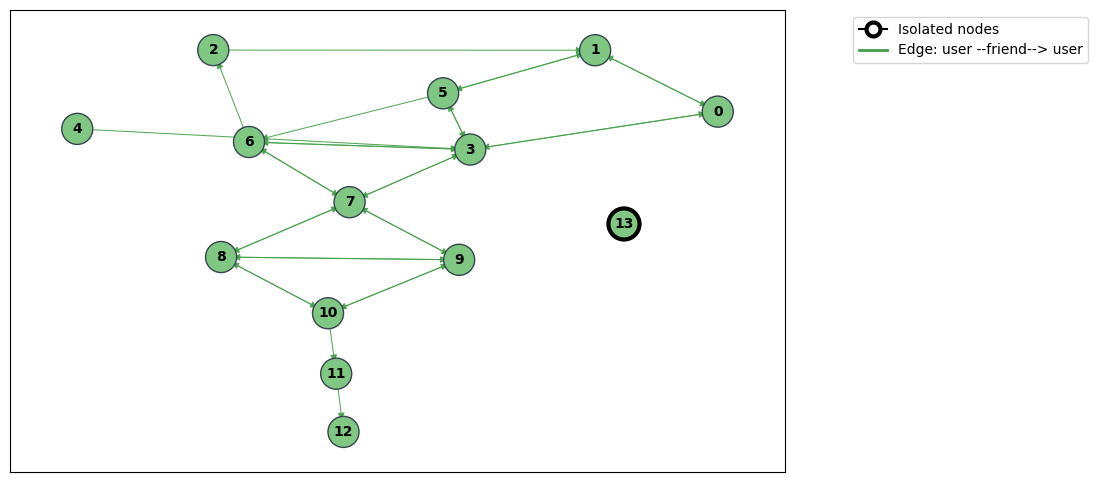

2025-08-01 20:26 [INFO] : BqUtils initialized with project: None (bq.py:__init__:62)
2025-08-01 20:26 [INFO] : Running query: 
                SELECT int_id, node_id FROM gigl-oss-onboarding-exp-test.svij_gigl_oss_tmp2.enumerated_node_user_ids_svij_gigl_toy_example_20250801_201317
                 (bq.py:run_query:129)


gs://svij-gigl-oss-tmp/svij_gigl_toy_example_20250801_201317/config_populator/frozen_gbml_config.yaml


In [16]:
from snapchat.research.gbml import training_samples_schema_pb2
from gigl.common.utils.jupyter_magics import GraphVisualizer, GraphVisualizerLayoutMode, PbVisualizer, PbVisualizerFromOutput

# We will sample node with this id and visualize it. You will see positive edge marked in red and the root node with a black border.
SAMPLE_NODE_ID = 9
# We will sample random negative nodes with these ids and visualize them. You will see the root node with a black border.
SAMPLE_RANDOM_NEGATIVE_NODE_IDS = [1, 3]

print(f"The original global graph:")
GraphVisualizer.visualize_graph(original_graph_heterodata, layout_mode=GraphVisualizerLayoutMode.HOMOGENEOUS)
pb_visualizer = PbVisualizer(frozen_task_config)
print (FROZEN_TASK_CONFIG_PATH)

Node anchor prediction sample for node 9:
The node id 9, type user maps to node id 9, type 0
 Looking for node 9 in gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/subgraph_sampler/node_anchor_based_link_prediction/node_anchor_based_link_prediction_samples/samples/*.tfrecord
Node anchor prediction sample for node 9:


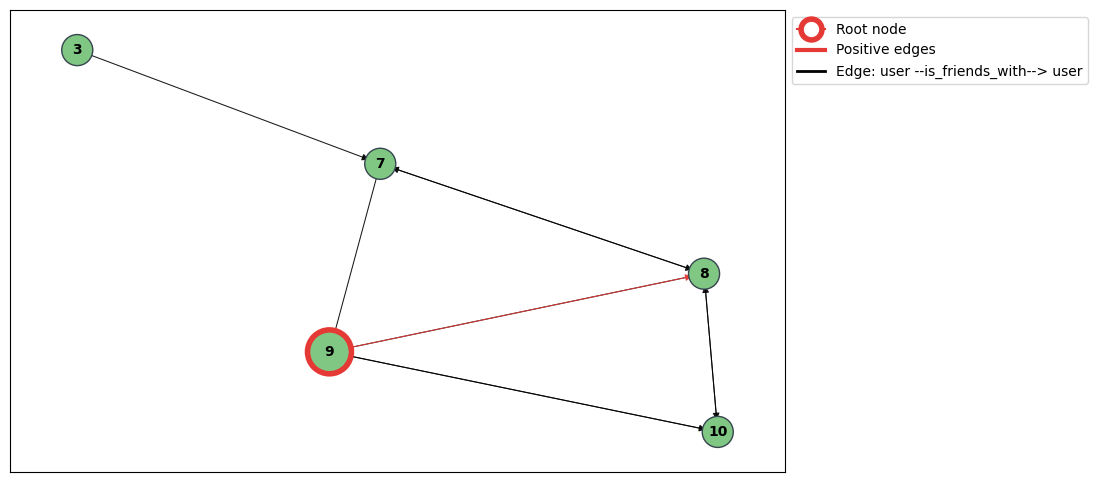

The node id 1, type user maps to node id 1, type 0
 Looking for node 1 in gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/subgraph_sampler/node_anchor_based_link_prediction/random_negative_rooted_neighborhood_samples/user/samples/*.tfrecord
Random negative sample for node 1:


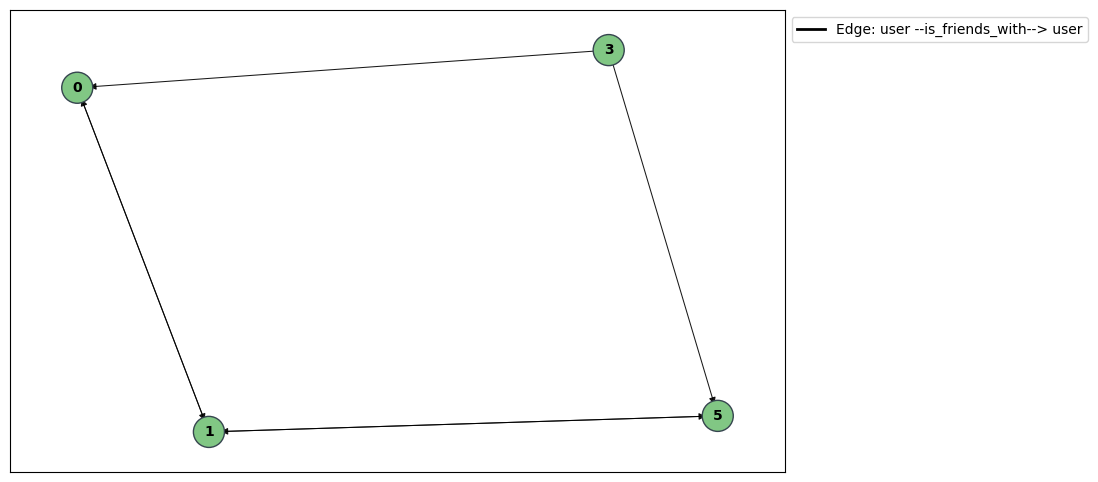

The node id 3, type user maps to node id 3, type 0
 Looking for node 3 in gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/subgraph_sampler/node_anchor_based_link_prediction/random_negative_rooted_neighborhood_samples/user/samples/*.tfrecord
Random negative sample for node 3:


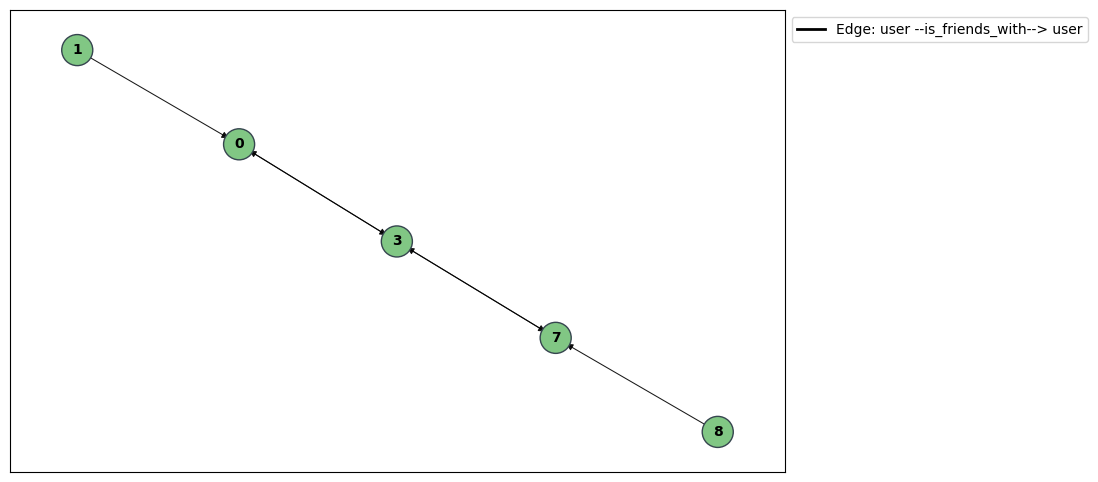

In [17]:
print(f"Node anchor prediction sample for node {SAMPLE_NODE_ID}:")
sample = pb_visualizer.find_node_pb(
    unenumerated_node_id=SAMPLE_NODE_ID,
    unenumerated_node_type="user",
    pb_type=training_samples_schema_pb2.NodeAnchorBasedLinkPredictionSample,
    from_output=PbVisualizerFromOutput.SGS
)
print(f"Node anchor prediction sample for node {SAMPLE_NODE_ID}:")
pb_visualizer.plot_pb(sample, layout_mode=GraphVisualizerLayoutMode.HOMOGENEOUS)

for random_negative_node_id in SAMPLE_RANDOM_NEGATIVE_NODE_IDS:
    random_negative_sample = pb_visualizer.find_node_pb(
        unenumerated_node_id=random_negative_node_id,
        unenumerated_node_type="user",
        pb_type=training_samples_schema_pb2.RootedNodeNeighborhood,
        from_output=PbVisualizerFromOutput.SGS
    )
    print(f"Random negative sample for node {random_negative_node_id}:")
    pb_visualizer.plot_pb(
        random_negative_sample,
        layout_mode=GraphVisualizerLayoutMode.HOMOGENEOUS,
    )

### Split Generator

The Split Generator reads localized subgraph samples produced by the Subgraph Sampler and executes the user-specified split strategy logic to split the data into training, validation, and test sets. Several standard configurations of SplitStrategy and corresponding Assigner classes are already implemented at a GiGL platform level: transductive node classification, inductive node classification, and transductive link prediction split routines. For more information on split strategies in Graph Machine Learning, check out these resources:

1. [CS224W Lecture Slides](http://web.stanford.edu/class/cs224w/slides/07-theory.pdf)
2. [Graph Link Prediction](https://zqfang.github.io/2021-08-12-graph-linkpredict/) (relevant for explaining transductive vs inductive).

In this example, we are using the transductive strategy as specified in our frozen_config:

In [18]:
print(frozen_task_config.dataset_config.split_generator_config)

split_strategy_cls_path: "splitgenerator.lib.split_strategies.TransductiveNodeAnchorBasedLinkPredictionSplitStrategy"
assigner_cls_path: "splitgenerator.lib.assigners.TransductiveEdgeToLinkSplitHashingAssigner"
assigner_args {
  key: "seed"
  value: "42"
}
assigner_args {
  key: "test_split"
  value: "0.2"
}
assigner_args {
  key: "train_split"
  value: "0.7"
}
assigner_args {
  key: "val_split"
  value: "0.1"
}



For transductive, at training time, it uses training message edges to predict training supervision edges. At validation time, the training message edges and training supervision edges are used to predict the validation edges and then all 3 are used to predict test edges. Below is the command to run split generator:


In [19]:
!python -m gigl.src.split_generator.split_generator \
--job_name=$JOB_NAME \
--task_config_uri=$FROZEN_TASK_CONFIG_PATH \
--resource_config_uri=$RESOURCE_CONFIG_PATH

2025-08-01 20:26:32.166923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-01 20:26:32.166967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-01 20:26:32.168228: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 20:26 [INFO] : Using Any for unsupported type: typing.Sequence[~T] (native_type_compatibility.py:convert_to_beam_type:340)
2025-08-01 20:26 [INFO] : Custom metrics class not provided. Using No-op metrics (metrics_service_provider.py:initialize_metrics:30)
2025-08-01 20:26 [INFO] : Skipping populating subgraph_sampling_strategy_pb_wrapper as the message

Upon completion, there will be 3 folders for train,test, and val. Each of them contains the protos for the positive and negaitve samples. The path for these folders is specified in the following location in the frozen_config:

In [20]:
dataset_metadata = frozen_task_config.shared_config.dataset_metadata
print(dataset_metadata)

node_anchor_based_link_prediction_dataset {
  train_main_data_uri: "gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/split_generator/train/main_samples/samples/"
  test_main_data_uri: "gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/split_generator/test/main_samples/samples/"
  val_main_data_uri: "gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/split_generator/val/main_samples/samples/"
  train_node_type_to_random_negative_data_uri {
    key: "user"
    value: "gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/split_generator/train/random_negatives/user/neighborhoods/"
  }
  val_node_type_to_random_negative_data_uri {
    key: "user"
    value: "gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/split_generator/val/random_negatives/user/neighborhoods/"
  }
  test_node_type_to_random_negative_data_uri {
    key: "user"
    value: "gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/split_generator/test/random_nega


We can visualize the train,test, and val samples for all nodes.
Note, for this specific task config setup, not all val amd test samples will have positive labels. This is because edges are randomly assigned into "train", "val", or "test" buckets independent of whether or not they are supervision edges. Thus, although at scale this setting is okay i.e. with large data and a large batch size each batch will have some supervision edges, it can be a case that certain batches dont have any supervision edges. Thus, your val/test loops and early stopping logic may need to be carefully designed.

Node anchor prediction sample for node 0:
The node id 0, type user maps to node id 0, type 0
 Looking for node 0 in gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/split_generator/train/main_samples/samples/*.tfrecord
The node id 0, type user maps to node id 0, type 0
 Looking for node 0 in gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/split_generator/val/main_samples/samples/*.tfrecord
The node id 0, type user maps to node id 0, type 0
 Looking for node 0 in gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/split_generator/test/main_samples/samples/*.tfrecord
No train sample found for node 0.
Validation sample for node 0:


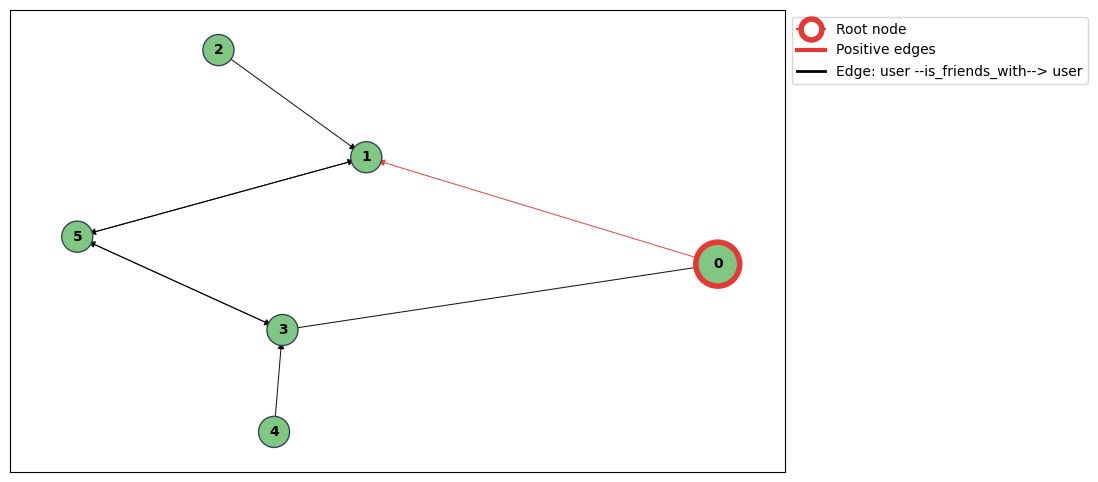

Test sample for node 0:


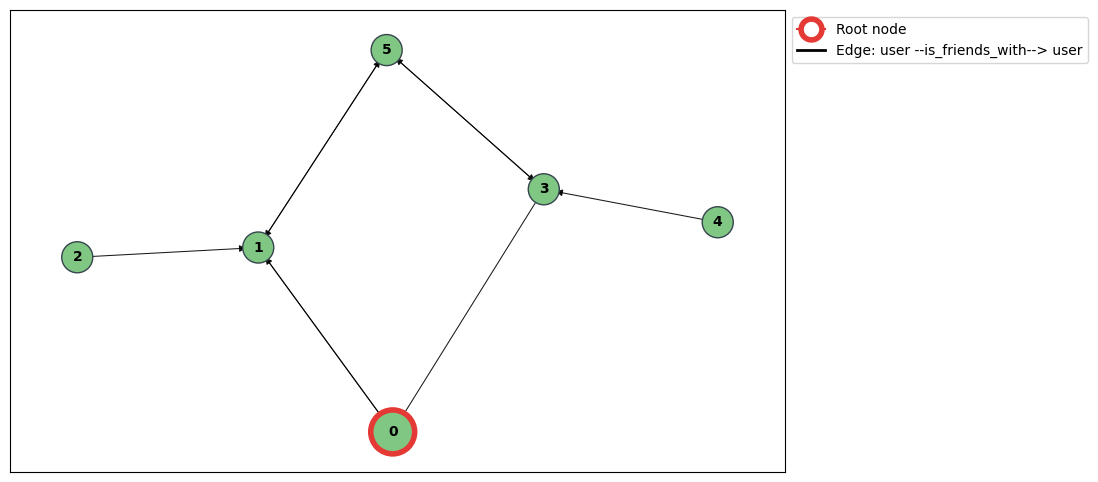

Node anchor prediction sample for node 1:
The node id 1, type user maps to node id 1, type 0
 Looking for node 1 in gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/split_generator/train/main_samples/samples/*.tfrecord
The node id 1, type user maps to node id 1, type 0
 Looking for node 1 in gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/split_generator/val/main_samples/samples/*.tfrecord
The node id 1, type user maps to node id 1, type 0
 Looking for node 1 in gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/split_generator/test/main_samples/samples/*.tfrecord
No train sample found for node 1.
Validation sample for node 1:


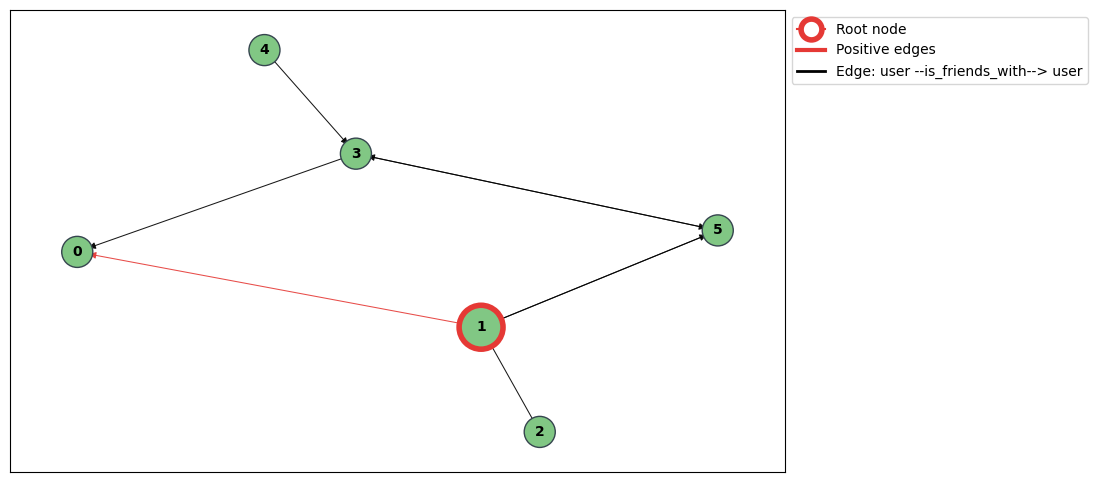

Test sample for node 1:


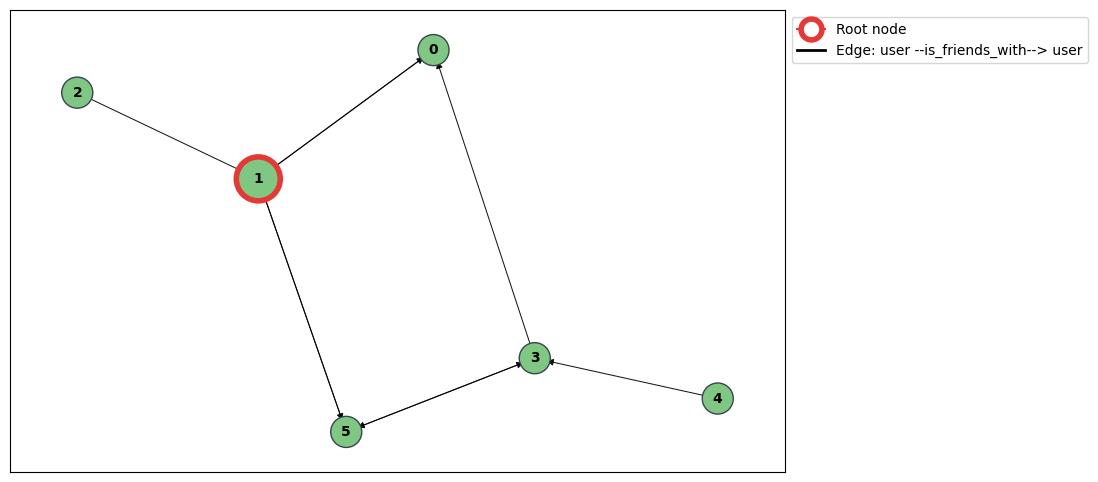

Node anchor prediction sample for node 2:
The node id 2, type user maps to node id 2, type 0
 Looking for node 2 in gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/split_generator/train/main_samples/samples/*.tfrecord
The node id 2, type user maps to node id 2, type 0
 Looking for node 2 in gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/split_generator/val/main_samples/samples/*.tfrecord
The node id 2, type user maps to node id 2, type 0
 Looking for node 2 in gs://svij-gigl-oss-perm/svij_gigl_toy_example_20250801_201317/split_generator/test/main_samples/samples/*.tfrecord
Train sample for node 2: 


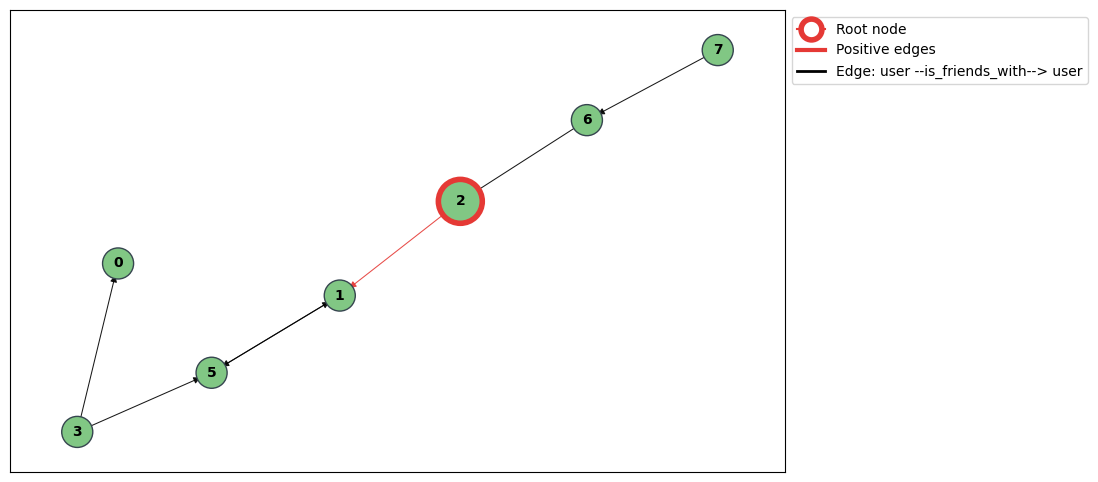

Validation sample for node 2:


In [ ]:
from gigl.common.utils.jupyter_magics import  GraphVisualizerLayoutMode


for node_id in range(max(original_graph_heterodata.num_nodes, 2)):
    print(f"Node anchor prediction sample for node {node_id}:")
    sample_train = pb_visualizer.find_node_pb(
        from_output=PbVisualizerFromOutput.SPLIT_TRAIN,
        unenumerated_node_id=node_id,
        unenumerated_node_type="user",
        pb_type=training_samples_schema_pb2.NodeAnchorBasedLinkPredictionSample
    )
    sample_val = pb_visualizer.find_node_pb(
        from_output=PbVisualizerFromOutput.SPLIT_VAL,
        unenumerated_node_id=node_id,
        unenumerated_node_type="user",
        pb_type=training_samples_schema_pb2.NodeAnchorBasedLinkPredictionSample
    )
    sample_test = pb_visualizer.find_node_pb(
        from_output=PbVisualizerFromOutput.SPLIT_TEST,
        unenumerated_node_id=node_id,
        unenumerated_node_type="user",
        pb_type=training_samples_schema_pb2.NodeAnchorBasedLinkPredictionSample
    )
    if sample_train:
        print(f"Train sample for node {node_id}: ")
        pb_visualizer.plot_pb(
            sample_train,
            layout_mode=GraphVisualizerLayoutMode.HOMOGENEOUS,
        )
    else:
        print(f"No train sample found for node {node_id}.")
    if sample_val:
        print(f"Validation sample for node {node_id}:")
        pb_visualizer.plot_pb(
            sample_val,
            layout_mode=GraphVisualizerLayoutMode.HOMOGENEOUS,
        )
    else:
        print(f"No validation sample found for node {node_id}.")
    if sample_test:
        print(f"Test sample for node {node_id}:")
        pb_visualizer.plot_pb(
            sample_test,
            layout_mode=GraphVisualizerLayoutMode.HOMOGENEOUS,
        )
    else:
        print(f"No test sample found for node {node_id}.")



At this point, we have our graph data samples ready to be processed by the trainer and inferencer components. These components will extract representations/embeddings by learning contextual information for the specified task.

## Training and Inference

Tabularized GiGL uses a config-based approach to training and inference. They use the [`GbmlConfig.TrainerConfig`](https://github.com/Snapchat/GiGL/blob/97fdb6e5d41f567900d729e9bb894a8f727dbd0c/proto/snapchat/research/gbml/gbml_config.proto#L176-L191) and [`GbmlConfig.InferencerConfig`](https://github.com/Snapchat/GiGL/blob/97fdb6e5d41f567900d729e9bb894a8f727dbd0c/proto/snapchat/research/gbml/gbml_config.proto#L193-L208) Proto messages.

In this case, they both use the [`NodeAnchorBasedLinkPredictionModelingTaskSpec`](https://github.com/Snapchat/GiGL/blob/97fdb6e5d41f567900d729e9bb894a8f727dbd0c/python/gigl/src/common/modeling_task_specs/node_anchor_based_link_prediction_modeling_task_spec.py#L66)

You can run the Trainer and Inferencer the same as the other components

In [22]:
!python -m gigl.src.training.trainer \
--job_name=$JOB_NAME \
--task_config_uri=$FROZEN_TASK_CONFIG_PATH \
--resource_config_uri=$RESOURCE_CONFIG_PATH \
--cpu_docker_uri=$DOCKER_IMAGE_MAIN_CPU_NAME_WITH_TAG \
--cuda_docker_uri=$DOCKER_IMAGE_MAIN_CUDA_NAME_WITH_TAG

2025-08-01 20:33:37.430512: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-01 20:33:37.430553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-01 20:33:37.431860: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 20:33 [INFO] : Using Any for unsupported type: typing.Sequence[~T] (native_type_compatibility.py:convert_to_beam_type:340)
2025-08-01 20:33 [INFO] : Custom metrics class not provided. Using No-op metrics (metrics_service_provider.py:initialize_metrics:30)
2025-08-01 20:33 [INFO] : Skipping populating subgraph_sampling_strategy_pb_wrapper as the message

In [23]:
# The model gets saved to the path specified in the frozen task config.
print(f"Trained model saved to: {frozen_task_config.shared_config.trained_model_metadata.trained_model_uri}")

Trained model saved to: gs://svij-gigl-oss-tmp/svij_gigl_toy_example_20250801_201317/trainer/models/model.pt


In [24]:
!python -m gigl.src.inference.inferencer \
--job_name=$JOB_NAME \
--task_config_uri=$FROZEN_TASK_CONFIG_PATH \
--resource_config_uri=$RESOURCE_CONFIG_PATH \
--cpu_docker_uri=$DOCKER_IMAGE_MAIN_CPU_NAME_WITH_TAG \
--cuda_docker_uri=$DOCKER_IMAGE_MAIN_CUDA_NAME_WITH_TAG \
--custom_worker_image_uri=$DOCKER_IMAGE_DATAFLOW_RUNTIME_NAME_WITH_TAG

2025-08-01 20:39:48.445921: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-01 20:39:48.445966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-01 20:39:48.447348: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 20:39 [INFO] : Using Any for unsupported type: typing.Sequence[~T] (native_type_compatibility.py:convert_to_beam_type:340)
2025-08-01 20:39 [INFO] : Custom metrics class not provided. Using No-op metrics (metrics_service_provider.py:initialize_metrics:30)
2025-08-01 20:39 [INFO] : Skipping populating subgraph_sampling_strategy_pb_wrapper as the message

In [25]:
# Looking at inference results

from gigl.src.common.utils.bq import BqUtils

bq_emb_out_table = frozen_task_config.shared_config.inference_metadata.node_type_to_inferencer_output_info_map[frozen_task_config.graph_metadata_pb_wrapper.homogeneous_node_type].embeddings_path
print(f"Embeddings should be successfully stored in the following location: {bq_emb_out_table}")

bq_utils = BqUtils(project=resource_config.project)
query = f"SELECT * FROM {bq_emb_out_table} LIMIT 5"
result = list(bq_utils.run_query(query=query, labels={}))

print(f"Query result: {result}")

2025-08-01 20:46 [INFO] : BqUtils initialized with project: gigl-oss-onboarding-exp-test (bq.py:__init__:62)
2025-08-01 20:46 [INFO] : Running query: SELECT * FROM gigl-oss-onboarding-exp-test.svij_gigl_oss_tmp2.embeddings_user_svij_gigl_toy_example_20250801_201317 LIMIT 5 (bq.py:run_query:129)


Embeddings should be successfully stored in the following location: gigl-oss-onboarding-exp-test.svij_gigl_oss_tmp2.embeddings_user_svij_gigl_toy_example_20250801_201317
Query result: [Row(('12', [-0.2710978388786316, -0.27177444100379944, 0.029366133734583855, -0.14443941414356232, -0.174445241689682, 0.08435279130935669, -0.19289086759090424, 0.12095119804143906, -0.25416848063468933, 0.16892892122268677, 0.19418808817863464, -0.13161607086658478, 0.4556041657924652, 0.265285462141037, 0.3696887195110321, -0.42278265953063965]), {'node_id': 0, 'emb': 1}), Row(('13', [-0.283087819814682, -0.22562241554260254, 0.0497906357049942, -0.2109861671924591, -0.03729236125946045, -0.05139864608645439, -0.29879385232925415, 0.20440413057804108, 0.042401738464832306, 0.23267634212970734, 0.15139536559581757, -0.08906375616788864, 0.45218154788017273, 0.17707476019859314, 0.1863487809896469, -0.5740484595298767]), {'node_id': 0, 'emb': 1}), Row(('5', [-0.26751309633255005, -0.2478242963552475, -0

## Vertex AI Pipelines

You can also run GiGL pipelines on [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction). Doing so provides a number of advantages, such as:

1. Decoupling orchestration from dev machines - when you close your laptop the pipeline keeps running
2. Orchestrate new runs from GCP console. You can start/stop runs on the console
3. Data isolation - production Service Accounts and Projects can access sensitive data

GiGL has a [`KfpOrchestrator`](https://snapchat.github.io/GiGL/docs/api/gigl/orchestration/kubeflow/kfp_orchestrator/index.html#gigl.orchestration.kubeflow.kfp_orchestrator.KfpOrchestrator) client which will let you launch GiGL pipelines on Vertex AI.

We need to call two methods on the client to start a new pipeline run:

1. [`compile`](https://snapchat.github.io/GiGL/_modules/gigl/orchestration/kubeflow/kfp_orchestrator.html#KfpOrchestrator.compile), which generates a KFP Pipeline spec that Vertex AI can consume to orchestrate the pipeline. Under the hood, we write the pipeline yaml to some local file, but you can configure this with the `dst_compiled_pipeline_path` argument.
2. [`run`](https://snapchat.github.io/GiGL/_modules/gigl/orchestration/kubeflow/kfp_orchestrator.html#KfpOrchestrator.run) which uploads the pipeline spec to Vertex AI and starts a new pipeline job. Note that `run` requires an applied_task_identifier (pipeline job name), which must be unique in every Project and Region.

Note that `compile` requires docker images to be passed in, this is because the docker images that are used by each component are baked into the pipeline definition. For this tutorial, we will be using the default images, however if you want to customize the buisness logic here,  you will need to provide your own docker images. GiGL has a handy [`script`](https://github.com/Snapchat/GiGL/blob/main/scripts/build_and_push_docker_image.py) will push the docker images for you. 

In [26]:
# You can also run the entire GiGL pipeline on Vertex AI
# With the KfpOrchestrator [1]
# Note that we use TEMPLATE_TASK_CONFIG_PATH here so we can have another "dataset" e.g. SharedConfig.
# [1]: https://snapchat.github.io/GiGL/docs/api/gigl/orchestration/kubeflow/kfp_orchestrator/index.html#gigl.orchestration.kubeflow.kfp_orchestrator.KfpOrchestrator
from gigl.orchestration.kubeflow.kfp_orchestrator import KfpOrchestrator

orchestrator = KfpOrchestrator()
# First, compile the KFP pipeline definition
orchestrator.compile(
    cuda_container_image=DOCKER_IMAGE_MAIN_CUDA_NAME_WITH_TAG,
    cpu_container_image=DOCKER_IMAGE_MAIN_CPU_NAME_WITH_TAG,
    dataflow_container_image=DOCKER_IMAGE_DATAFLOW_RUNTIME_NAME_WITH_TAG,
)
# Then, run it.
orchestrator.run(
    applied_task_identifier=JOB_NAME,
    task_config_uri=TEMPLATE_TASK_CONFIG_PATH,
    resource_config_uri=RESOURCE_CONFIG_PATH,
)

# You'll eventually see a link to the KFP pipeline in the logs.
# Something like: 
# https://console.cloud.google.com/vertex-ai/pipelines/locations/us-central1/runs/<job_id>

2025-08-01 20:46 [INFO] : Compiling pipeline to /home/svij/GiGL/build/gigl_pipeline_gnn.yaml (kfp_orchestrator.py:compile:81)
2025-08-01 20:46 [INFO] : Compiled Kubeflow pipeline to /home/svij/GiGL/build/gigl_pipeline_gnn.yaml (kfp_orchestrator.py:compile:98)
2025-08-01 20:46 [INFO] : Uploading compiled pipeline to /home/svij/GiGL/build/gigl_pipeline_gnn.yaml (kfp_orchestrator.py:compile:100)
2025-08-01 20:46 [INFO] : Config validation check: if job_name: svij_gigl_toy_example_20250801_201317 is valid. (name_checks.py:check_if_kfp_pipeline_job_name_valid:15)
2025-08-01 20:46 [INFO] : Skipping pipeline compilation; will use /home/svij/GiGL/build/gigl_pipeline_gnn.yaml (kfp_orchestrator.py:run:139)
2025-08-01 20:46 [INFO] : Running pipeline with args: {'job_name': 'svij_gigl_toy_example_20250801_201317', 'start_at': 'config_populator', 'template_or_frozen_config_uri': 'examples/toy_visual_example/template_task_config.yaml', 'resource_config_uri': 'gs://svij-gigl-oss-tmp/svij/20250731_001

resource name: projects/886685870037/locations/us-central1/pipelineJobs/svij-gigl-toy-example-20250801-201317